# Di Tella 2017
This file replicates the results from [Di Tella 2017, Uncertainty Shocks and Balance Sheet Recessions](https://gsb-faculty.stanford.edu/sebastian-di-tella/files/2022/10/DiTella_Unc_Shocks_2556027.pdf)

In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from deep_macrofin import PDEModelTimeStep
from deep_macrofin import ActivationType, OptimizerType, SamplingMethod, plot_loss_df, set_seeds

In [2]:
latex_var_mapping = {
    # variables
    r"\iota": "iota",
    r"\hat{e}": "e_hat",
    r"\hat{c}": "c_hat",
    r"\sigma_{x,1}": "sigxtop",
    r"\sigma_{x,2}": "sigxbot",
    r"\sigma_x": "sigx",
    r"\sigma_p": "sigp",
    r"\sigma_\xi": "sigxi",
    r"\sigma_\zeta": "sigzeta",
    r"\tilde{\sigma_n}": "signtilde",
    r"\sigma_n": "sign",
    r"\pi": "signxi",
    r"\sigma_w": "sigw",
    r"\mu_n": "mun",
    r"\mu_x": "mux",
    r"\mu_p": "mup",
    r"\mu_\xi": "muxi",
    r"\mu_\zeta": "muzeta",
    r"\mu_w": "muw",

    # agents
    r"\xi": "xi",
    r"\zeta": "zeta",

    # constants
    r"\bar{\sigma_v}": "sigv_mean",
    r"\sigma_v": "sigv",
    r"\mu_v": "muv",
    r"\sigma": "sigma",
    r"\lambda": "lbd",
    r"\bar{v}": "v_mean",
    r"\rho": "rho",
    r"\gamma": "gamma",
    r"\psi": "psi",
    r"\tau": "tau",
    r"\delta": "delta",
    r"\phi": "phi",
}
MODEL_DIR = "./models/ditella_rar"

In [3]:
set_seeds(0)
pde_model = PDEModelTimeStep("ditella", 
                     {"batch_size": 500, "time_batch_size": 1, "sampling_method": SamplingMethod.RARG, 
                      "num_outer_iterations": 50, "num_inner_iterations": 5000}, 
                     latex_var_mapping)
pde_model.set_state(["x", "v"], {"x": [0.05, 0.95], "v": [0.05, 0.95]})
pde_model.add_agents(["xi", "zeta"], 
                     {"xi": {
                         "positive": True, 
                        }, 
                      "zeta": {
                          "positive": True, 
                          }
                     })
pde_model.add_endogs(["p", "r"], 
                     {"p": {
                         "positive": True, 
                         },
                     })
# pde_model.set_initial_guess({"p": 7.0})
pde_model.add_params({
    "a": 1,
    "sigma": 0.0125,
    "lbd": 1.38,
    "v_mean": 0.25,
    "sigv_mean": -0.17,
    "rho": 0.0665,
    "gamma": 5,
    "psi": 0.5,
    "tau": 1.15,
    "phi": 0.2,

    "A": 53.2,
    "B": -0.8668571428571438,
    "delta": 0.05,
})
pde_model.add_equation(r"$g &= \frac{1}{2*A} * (p - B) - \delta$") # g &= \frac{1}{2*A} * (p - B) - \delta
pde_model.add_equation(r"$\iota &= A * (g+\delta)^2 + B * (g+\delta)$") # \iota &= A * (g+\delta)^2 + B * (g+\delta)
pde_model.add_equation(r"$\mu_v &= \lambda * (\bar{v} - v)$")
pde_model.add_equation(r"$\sigma_v &= \bar{\sigma_v} * \sqrt{v}$")
pde_model.add_equation(r"$\hat{e} &= \rho^{1/\psi} * \xi^{(\psi-1)/\psi}$")
pde_model.add_equation(r"$\hat{c} &= \rho^{1/\psi} * \zeta^{(\psi-1)/\psi}$")
pde_model.add_equation(r"$\sigma_{x,1} &= (1-x) * x * \frac{1-\gamma}{\gamma} * \left( \frac{1}{\xi} * \frac{\partial \xi}{\partial v} - \frac{1}{\zeta} * \frac{\partial \zeta}{\partial v} \right)$")
pde_model.add_equation(r"$\sigma_{x,2} &= 1 - (1-x) * x * \frac{1-\gamma}{\gamma} * \left( \frac{1}{\xi} * \frac{\partial \xi}{\partial x} - \frac{1}{\zeta} * \frac{\partial \zeta}{\partial x} \right)$")
pde_model.add_equation(r"$\sigma_x &= \frac{\sigma_{x,1}}{\sigma_{x,2}} * \sigma_v$")
pde_model.add_equation(r"$\sigma_p &= \frac{1}{p} * \left( \frac{\partial p}{\partial v} * \sigma_v + \frac{\partial p}{\partial x} * \sigma_x \right)$")
pde_model.add_equation(r"$\sigma_\xi &= \frac{1}{\xi} * \left( \frac{\partial \xi}{\partial v} * \sigma_v + \frac{\partial \xi}{\partial x} * \sigma_x \right)$")
pde_model.add_equation(r"$\sigma_\zeta &= \frac{1}{\zeta} * \left( \frac{\partial \zeta}{\partial v} * \sigma_v + \frac{\partial \zeta}{\partial x} * \sigma_x \right)$")
pde_model.add_equation(r"$\sigma_n &= \sigma + \sigma_p + \frac{\sigma_x}{x}$")
pde_model.add_equation(r"$\pi &= \gamma * \sigma_n + (\gamma-1) * \sigma_\xi$")
pde_model.add_equation(r"$\sigma_w &= \frac{\pi}{\gamma} - \frac{\gamma-1}{\gamma} *  \sigma_\zeta$")
pde_model.add_equation(r"$\mu_w &= r + \pi * \sigma_w$")
pde_model.add_equation(r"$\mu_n &= r + \frac{\gamma}{x^2} * (\phi * v)^2 + \pi * \sigma_n$")
pde_model.add_equation(r"$\tilde{\sigma_n} &= \frac{\phi}{x} * v$")
pde_model.add_equation(r"$\mu_x &= x * \left(\mu_n - \hat{e} - \tau + \frac{a-\iota}{p} - r - \pi * (\sigma+\sigma_p) - \frac{\gamma}{x} * (\phi * v)^2 + (\sigma + \sigma_p)^2 - \sigma_n * (\sigma + \sigma_p)\right)$")
pde_model.add_equation(r"$\mu_p &= \frac{1}{p} * \left( \frac{\partial p}{\partial t} + \mu_v * \frac{\partial p}{\partial v} + \mu_x * \frac{\partial p}{\partial x} + \frac{1}{2} * \left( \sigma_v^2 * \frac{\partial^2 p}{\partial v^2} + 2 * \sigma_v * \sigma_x * \frac{\partial^2 p}{\partial v \partial x} + \sigma_x^2 * \frac{\partial^2 p}{\partial x^2} \right)\right)$")
pde_model.add_equation(r"$\mu_\xi &= \frac{1}{\xi} * \left( \frac{\partial \xi}{\partial t} + \mu_v * \frac{\partial \xi}{\partial v} + \mu_x * \frac{\partial \xi}{\partial x} + \frac{1}{2} * \left( \sigma_v^2 * \frac{\partial^2 \xi}{\partial v^2} + 2 * \sigma_v * \sigma_x * \frac{\partial^2 \xi}{\partial v \partial x} + \sigma_x^2 * \frac{\partial^2 \xi}{\partial x^2} \right)\right)$")
pde_model.add_equation(r"$\mu_\zeta &= \frac{1}{\zeta} * \left( \frac{\partial \zeta}{\partial t} + \mu_v * \frac{\partial \zeta}{\partial v} + \mu_x * \frac{\partial \zeta}{\partial x} + \frac{1}{2} * \left( \sigma_v^2 * \frac{\partial^2 \zeta}{\partial v^2} + 2 * \sigma_v * \sigma_x * \frac{\partial^2 \zeta}{\partial v \partial x} + \sigma_x^2 * \frac{\partial^2 \zeta}{\partial x^2} \right)\right)$")

pde_model.add_endog_equation(r"$a - \iota &= p * (\hat{e} * x + \hat{c} * (1-x))$")
pde_model.add_endog_equation(r"$\sigma + \sigma_p &= \sigma_n * x + \sigma_w * (1-x)$")
pde_model.add_endog_equation(r"$\frac{a-\iota}{p} + g + \mu_p + \sigma * \sigma_p - r &= (\sigma + \sigma_p) * \pi + \gamma * \frac{1}{x} * (\phi * v)^2$")

pde_model.add_hjb_equation(r"$\frac{\hat{e}^{1-\psi}}{1-\psi} * \rho * \xi^{\psi-1} + \frac{\tau}{1-\gamma} * \left(\left(\frac{\zeta}{\xi} \right)^{1-\gamma}-1 \right) + \mu_n - \hat{e} + \mu_\xi - \frac{\gamma}{2} * \left( \sigma_n^2 + \sigma_\xi^2 - 2 * \frac{1-\gamma}{\gamma} * \sigma_n * \sigma_\xi + \tilde{\sigma_n}^2 \right) - \frac{\rho}{1-\psi}$")
pde_model.add_hjb_equation(r"$\frac{\hat{c}^{1-\psi}}{1-\psi} * \rho * \zeta^{\psi-1} + \mu_w - \hat{c} + \mu_\zeta - \frac{\gamma}{2} * \left( \sigma_w^2 + \sigma_\zeta^2 - 2 * \frac{1-\gamma}{\gamma} * \sigma_w * \sigma_\zeta \right) - \frac{\rho}{1-\psi}$")
print(pde_model)
if not os.path.exists(f"{MODEL_DIR}/model.pt"):
    pde_model.train_model(MODEL_DIR, "model.pt", True)
    pde_model.load_model(torch.load(f"{MODEL_DIR}/model_best.pt", weights_only=False))
    pde_model.eval_model(True)
else:
    pde_model.load_model(torch.load(f"{MODEL_DIR}/model_best.pt", weights_only=False))
    pde_model.eval_model(True)

============================Summary of Model ditella============================
Config: {
 "batch_size": 500,
 "time_batch_size": 1,
 "num_outer_iterations": 50,
 "num_inner_iterations": 5000,
 "lr": 0.001,
 "optimizer_type": "Adam",
 "min_t": 0.0,
 "max_t": 1.0,
 "outer_loop_convergence_thres": 0.0001,
 "sampling_method": "RAR-G",
 "refinement_rounds": 5,
 "loss_balancing": false,
 "bernoulli_prob": 0.9999,
 "loss_balancing_temp": 0.1,
 "loss_balancing_alpha": 0.999
}
Latex Variable Mapping:
{
 "\\iota": "iota",
 "\\hat{e}": "e_hat",
 "\\hat{c}": "c_hat",
 "\\sigma_{x,1}": "sigxtop",
 "\\sigma_{x,2}": "sigxbot",
 "\\sigma_x": "sigx",
 "\\sigma_p": "sigp",
 "\\sigma_\\xi": "sigxi",
 "\\sigma_\\zeta": "sigzeta",
 "\\tilde{\\sigma_n}": "signtilde",
 "\\sigma_n": "sign",
 "\\pi": "signxi",
 "\\sigma_w": "sigw",
 "\\mu_n": "mun",
 "\\mu_x": "mux",
 "\\mu_p": "mup",
 "\\mu_\\xi": "muxi",
 "\\mu_\\zeta": "muzeta",
 "\\mu_w": "muw",
 "\\xi": "xi",
 "\\zeta": "zeta",
 "\\bar{\\sigma_v}": "sig

Min loss: 0.9872: 100%|██████████| 5000/5000 [18:13<00:00,  4.57it/s]


Model loaded
xi: Mean Value: 1.29792, Absolute Change: 0.29792, Relative Change:  0.29792
zeta: Mean Value: 1.15089, Absolute Change: 0.15089, Relative Change:  0.15089
p: Mean Value: 1.57491, Absolute Change: 0.57491, Relative Change:  0.57491
r: Mean Value: 0.07088, Absolute Change: 0.92912, Relative Change:  0.92912
Updating min loss from inf to 0.9872
Outer Loop 0 Finished in 1093.3273s. Loading best model...


Min loss: 0.3605: 100%|██████████| 3535/3535 [12:35<00:00,  4.68it/s]


Model loaded
xi: Mean Value: 0.16561, Absolute Change: 1.13230, Relative Change:  0.87239
zeta: Mean Value: 0.14012, Absolute Change: 1.01077, Relative Change:  0.87826
p: Mean Value: 12.24849, Absolute Change: 10.67357, Relative Change:  6.77844
r: Mean Value: 0.08628, Absolute Change: 0.02047, Relative Change:  0.42160
Updating min loss from 0.9872 to 0.6889
Outer Loop 1 Finished in 755.6010s. Loading best model...


Min loss: 0.0105: 100%|██████████| 2886/2886 [10:15<00:00,  4.69it/s]


Model loaded
xi: Mean Value: 0.15433, Absolute Change: 0.01152, Relative Change:  0.06573
zeta: Mean Value: 0.13294, Absolute Change: 0.00772, Relative Change:  0.05568
p: Mean Value: 11.79878, Absolute Change: 0.45004, Relative Change:  0.03618
r: Mean Value: 0.01564, Absolute Change: 0.07206, Relative Change:  6.22920
Updating min loss from 0.6889 to 0.0112
Outer Loop 2 Finished in 615.9270s. Loading best model...


Min loss: 0.0021: 100%|██████████| 2500/2500 [08:53<00:00,  4.69it/s]


Model loaded
xi: Mean Value: 0.14465, Absolute Change: 0.00968, Relative Change:  0.06261
zeta: Mean Value: 0.12355, Absolute Change: 0.00939, Relative Change:  0.07091
p: Mean Value: 11.24942, Absolute Change: 0.54937, Relative Change:  0.04644
r: Mean Value: 0.03554, Absolute Change: 0.01990, Relative Change:  1.11918
Updating min loss from 0.0112 to 0.0091
Outer Loop 3 Finished in 533.2682s. Loading best model...


Min loss: 0.0022: 100%|██████████| 2236/2236 [07:52<00:00,  4.73it/s]


Model loaded
xi: Mean Value: 0.13016, Absolute Change: 0.01449, Relative Change:  0.10055
zeta: Mean Value: 0.11207, Absolute Change: 0.01148, Relative Change:  0.09275
p: Mean Value: 11.05417, Absolute Change: 0.19525, Relative Change:  0.01733
r: Mean Value: 0.02561, Absolute Change: 0.00992, Relative Change:  0.30323
Outer Loop 4 Finished in 472.3687s. Loading best model...


Min loss: 0.0016: 100%|██████████| 2041/2041 [07:10<00:00,  4.74it/s]


Model loaded
xi: Mean Value: 0.11884, Absolute Change: 0.01132, Relative Change:  0.08673
zeta: Mean Value: 0.10178, Absolute Change: 0.01028, Relative Change:  0.09178
p: Mean Value: 10.72583, Absolute Change: 0.32834, Relative Change:  0.02969
r: Mean Value: 0.03399, Absolute Change: 0.00837, Relative Change:  0.70093
Outer Loop 5 Finished in 430.7623s. Loading best model...


Min loss: 0.0015: 100%|██████████| 1889/1889 [06:37<00:00,  4.76it/s]


Model loaded
xi: Mean Value: 0.10857, Absolute Change: 0.01027, Relative Change:  0.08653
zeta: Mean Value: 0.09313, Absolute Change: 0.00865, Relative Change:  0.08502
p: Mean Value: 10.48458, Absolute Change: 0.24125, Relative Change:  0.02250
r: Mean Value: 0.02645, Absolute Change: 0.00754, Relative Change:  0.66863
Outer Loop 6 Finished in 397.0176s. Loading best model...


Min loss: 0.0015: 100%|██████████| 1767/1767 [06:12<00:00,  4.75it/s]


Model loaded
xi: Mean Value: 0.10172, Absolute Change: 0.00685, Relative Change:  0.06325
zeta: Mean Value: 0.08750, Absolute Change: 0.00563, Relative Change:  0.06043
p: Mean Value: 10.29206, Absolute Change: 0.19252, Relative Change:  0.01841
r: Mean Value: 0.02238, Absolute Change: 0.00408, Relative Change:  0.23167
Updating min loss from 0.0091 to 0.0081
Outer Loop 7 Finished in 372.0632s. Loading best model...


Min loss: 0.0016: 100%|██████████| 1666/1666 [05:45<00:00,  4.82it/s]


Model loaded
xi: Mean Value: 0.09752, Absolute Change: 0.00420, Relative Change:  0.04154
zeta: Mean Value: 0.08417, Absolute Change: 0.00333, Relative Change:  0.03786
p: Mean Value: 10.13122, Absolute Change: 0.16084, Relative Change:  0.01562
r: Mean Value: 0.02243, Absolute Change: 0.00072, Relative Change:  0.01939
Updating min loss from 0.0081 to 0.0080
Outer Loop 8 Finished in 345.7880s. Loading best model...


Min loss: 0.0013: 100%|██████████| 1581/1581 [05:31<00:00,  4.77it/s]


Model loaded
xi: Mean Value: 0.09281, Absolute Change: 0.00471, Relative Change:  0.04816
zeta: Mean Value: 0.08016, Absolute Change: 0.00401, Relative Change:  0.04775
p: Mean Value: 9.96019, Absolute Change: 0.17103, Relative Change:  0.01689
r: Mean Value: 0.02218, Absolute Change: 0.00082, Relative Change:  0.02976
Outer Loop 9 Finished in 331.7154s. Loading best model...


Min loss: 0.0015: 100%|██████████| 1507/1507 [05:16<00:00,  4.76it/s]


Model loaded
xi: Mean Value: 0.08845, Absolute Change: 0.00437, Relative Change:  0.04718
zeta: Mean Value: 0.07639, Absolute Change: 0.00377, Relative Change:  0.04700
p: Mean Value: 9.78970, Absolute Change: 0.17049, Relative Change:  0.01712
r: Mean Value: 0.02135, Absolute Change: 0.00098, Relative Change:  0.05756
Updating min loss from 0.0080 to 0.0079
Outer Loop 10 Finished in 316.6111s. Loading best model...


Min loss: 0.0011: 100%|██████████| 1443/1443 [04:59<00:00,  4.82it/s]


Model loaded
xi: Mean Value: 0.08401, Absolute Change: 0.00444, Relative Change:  0.04982
zeta: Mean Value: 0.07222, Absolute Change: 0.00417, Relative Change:  0.05475
p: Mean Value: 9.57210, Absolute Change: 0.21760, Relative Change:  0.02224
r: Mean Value: 0.02642, Absolute Change: 0.00507, Relative Change:  0.17176
Updating min loss from 0.0079 to 0.0077
Outer Loop 11 Finished in 299.3677s. Loading best model...


Min loss: 0.0012: 100%|██████████| 1386/1386 [04:46<00:00,  4.83it/s]


Model loaded
xi: Mean Value: 0.08054, Absolute Change: 0.00347, Relative Change:  0.04142
zeta: Mean Value: 0.06961, Absolute Change: 0.00261, Relative Change:  0.03614
p: Mean Value: 9.46135, Absolute Change: 0.11074, Relative Change:  0.01153
r: Mean Value: 0.01950, Absolute Change: 0.00691, Relative Change:  0.37566
Updating min loss from 0.0077 to 0.0064
Outer Loop 12 Finished in 286.7345s. Loading best model...


Min loss: 0.0009: 100%|██████████| 1336/1336 [04:37<00:00,  4.81it/s]


Model loaded
xi: Mean Value: 0.07760, Absolute Change: 0.00294, Relative Change:  0.03632
zeta: Mean Value: 0.06686, Absolute Change: 0.00275, Relative Change:  0.03958
p: Mean Value: 9.29374, Absolute Change: 0.16761, Relative Change:  0.01774
r: Mean Value: 0.01977, Absolute Change: 0.00091, Relative Change:  0.02410
Outer Loop 13 Finished in 277.5602s. Loading best model...


Min loss: 0.0012: 100%|██████████| 1290/1290 [04:29<00:00,  4.78it/s]


Model loaded
xi: Mean Value: 0.07519, Absolute Change: 0.00241, Relative Change:  0.03125
zeta: Mean Value: 0.06498, Absolute Change: 0.00188, Relative Change:  0.02795
p: Mean Value: 9.19738, Absolute Change: 0.09636, Relative Change:  0.01036
r: Mean Value: 0.01401, Absolute Change: 0.00576, Relative Change:  0.24855
Updating min loss from 0.0064 to 0.0058
Outer Loop 14 Finished in 269.7143s. Loading best model...


Min loss: 0.0011: 100%|██████████| 1250/1250 [04:23<00:00,  4.75it/s]


Model loaded
xi: Mean Value: 0.07356, Absolute Change: 0.00163, Relative Change:  0.02195
zeta: Mean Value: 0.06371, Absolute Change: 0.00128, Relative Change:  0.01952
p: Mean Value: 9.10760, Absolute Change: 0.08977, Relative Change:  0.00978
r: Mean Value: 0.01192, Absolute Change: 0.00213, Relative Change:  0.06995
Outer Loop 15 Finished in 263.2324s. Loading best model...


Min loss: 0.0010: 100%|██████████| 1212/1212 [04:18<00:00,  4.69it/s]


Model loaded
xi: Mean Value: 0.07168, Absolute Change: 0.00187, Relative Change:  0.02539
zeta: Mean Value: 0.06205, Absolute Change: 0.00166, Relative Change:  0.02612
p: Mean Value: 8.99751, Absolute Change: 0.11010, Relative Change:  0.01210
r: Mean Value: 0.01470, Absolute Change: 0.00278, Relative Change:  0.18348
Outer Loop 16 Finished in 258.1742s. Loading best model...


Min loss: 0.0011: 100%|██████████| 1178/1178 [04:09<00:00,  4.73it/s]


Model loaded
xi: Mean Value: 0.07040, Absolute Change: 0.00128, Relative Change:  0.01801
zeta: Mean Value: 0.06119, Absolute Change: 0.00085, Relative Change:  0.01374
p: Mean Value: 8.93445, Absolute Change: 0.06306, Relative Change:  0.00696
r: Mean Value: 0.01066, Absolute Change: 0.00403, Relative Change:  0.13071
Outer Loop 17 Finished in 249.0305s. Loading best model...


Min loss: 0.0011: 100%|██████████| 1147/1147 [04:01<00:00,  4.76it/s]


Model loaded
xi: Mean Value: 0.06874, Absolute Change: 0.00167, Relative Change:  0.02347
zeta: Mean Value: 0.05960, Absolute Change: 0.00159, Relative Change:  0.02614
p: Mean Value: 8.83773, Absolute Change: 0.09671, Relative Change:  0.01085
r: Mean Value: 0.01347, Absolute Change: 0.00281, Relative Change:  0.28031
Outer Loop 18 Finished in 241.1753s. Loading best model...


Min loss: 0.0010: 100%|██████████| 1118/1118 [03:52<00:00,  4.81it/s]


Model loaded
xi: Mean Value: 0.06763, Absolute Change: 0.00111, Relative Change:  0.01633
zeta: Mean Value: 0.05888, Absolute Change: 0.00072, Relative Change:  0.01196
p: Mean Value: 8.78393, Absolute Change: 0.05380, Relative Change:  0.00606
r: Mean Value: 0.00929, Absolute Change: 0.00418, Relative Change:  0.14314
Outer Loop 19 Finished in 232.4279s. Loading best model...


Min loss: 0.0009: 100%|██████████| 1091/1091 [03:48<00:00,  4.78it/s]


Model loaded
xi: Mean Value: 0.06646, Absolute Change: 0.00116, Relative Change:  0.01700
zeta: Mean Value: 0.05768, Absolute Change: 0.00120, Relative Change:  0.02042
p: Mean Value: 8.70363, Absolute Change: 0.08030, Relative Change:  0.00916
r: Mean Value: 0.01063, Absolute Change: 0.00201, Relative Change:  0.08754
Updating min loss from 0.0058 to 0.0057
Outer Loop 20 Finished in 228.2407s. Loading best model...


Min loss: 0.0011: 100%|██████████| 1066/1066 [03:44<00:00,  4.76it/s]


Model loaded
xi: Mean Value: 0.06546, Absolute Change: 0.00100, Relative Change:  0.01521
zeta: Mean Value: 0.05695, Absolute Change: 0.00073, Relative Change:  0.01257
p: Mean Value: 8.65961, Absolute Change: 0.04402, Relative Change:  0.00503
r: Mean Value: 0.00667, Absolute Change: 0.00396, Relative Change:  0.31605
Updating min loss from 0.0057 to 0.0055
Outer Loop 21 Finished in 224.1064s. Loading best model...


Min loss: 0.0013: 100%|██████████| 1042/1042 [03:37<00:00,  4.79it/s]


Model loaded
xi: Mean Value: 0.06505, Absolute Change: 0.00043, Relative Change:  0.00680
zeta: Mean Value: 0.05683, Absolute Change: 0.00013, Relative Change:  0.00229
p: Mean Value: 8.64214, Absolute Change: 0.01895, Relative Change:  0.00216
r: Mean Value: 0.00396, Absolute Change: 0.00272, Relative Change:  0.13415
Outer Loop 22 Finished in 217.5702s. Loading best model...


Min loss: 0.0008: 100%|██████████| 1020/1020 [03:29<00:00,  4.86it/s]


Model loaded
xi: Mean Value: 0.06465, Absolute Change: 0.00039, Relative Change:  0.00583
zeta: Mean Value: 0.05635, Absolute Change: 0.00048, Relative Change:  0.00860
p: Mean Value: 8.58651, Absolute Change: 0.05563, Relative Change:  0.00647
r: Mean Value: 0.00915, Absolute Change: 0.00519, Relative Change:  0.19857
Outer Loop 23 Finished in 209.7710s. Loading best model...


Min loss: 0.0013: 100%|██████████| 1000/1000 [03:27<00:00,  4.82it/s]


Model loaded
xi: Mean Value: 0.06402, Absolute Change: 0.00065, Relative Change:  0.01033
zeta: Mean Value: 0.05602, Absolute Change: 0.00032, Relative Change:  0.00569
p: Mean Value: 8.58319, Absolute Change: 0.01195, Relative Change:  0.00140
r: Mean Value: 0.00183, Absolute Change: 0.00732, Relative Change:  0.81209
Outer Loop 24 Finished in 207.5169s. Loading best model...


Min loss: 0.0008: 100%|██████████| 980/980 [03:23<00:00,  4.80it/s]


Model loaded
xi: Mean Value: 0.06378, Absolute Change: 0.00025, Relative Change:  0.00360
zeta: Mean Value: 0.05565, Absolute Change: 0.00038, Relative Change:  0.00679
p: Mean Value: 8.55485, Absolute Change: 0.02835, Relative Change:  0.00330
r: Mean Value: 0.00480, Absolute Change: 0.00301, Relative Change:  0.18924
Updating min loss from 0.0055 to 0.0050
Outer Loop 25 Finished in 203.9964s. Loading best model...


Min loss: 0.0009: 100%|██████████| 962/962 [03:20<00:00,  4.80it/s]


Model loaded
xi: Mean Value: 0.06334, Absolute Change: 0.00045, Relative Change:  0.00714
zeta: Mean Value: 0.05537, Absolute Change: 0.00028, Relative Change:  0.00483
p: Mean Value: 8.51670, Absolute Change: 0.03815, Relative Change:  0.00448
r: Mean Value: 0.00615, Absolute Change: 0.00195, Relative Change:  0.08067
Outer Loop 26 Finished in 200.2190s. Loading best model...


Min loss: 0.0008: 100%|██████████| 944/944 [03:15<00:00,  4.83it/s]


Model loaded
xi: Mean Value: 0.06295, Absolute Change: 0.00039, Relative Change:  0.00616
zeta: Mean Value: 0.05523, Absolute Change: 0.00015, Relative Change:  0.00266
p: Mean Value: 8.51489, Absolute Change: 0.00597, Relative Change:  0.00071
r: Mean Value: 0.00245, Absolute Change: 0.00373, Relative Change:  2.81349
Outer Loop 27 Finished in 195.4581s. Loading best model...


Min loss: 0.0013: 100%|██████████| 928/928 [03:13<00:00,  4.79it/s]


Model loaded
xi: Mean Value: 0.06269, Absolute Change: 0.00031, Relative Change:  0.00500
zeta: Mean Value: 0.05512, Absolute Change: 0.00011, Relative Change:  0.00209
p: Mean Value: 8.49834, Absolute Change: 0.01655, Relative Change:  0.00194
r: Mean Value: 0.00409, Absolute Change: 0.00184, Relative Change:  0.09510
Outer Loop 28 Finished in 193.6731s. Loading best model...


Min loss: 0.0012: 100%|██████████| 912/912 [03:06<00:00,  4.90it/s]


Model loaded
xi: Mean Value: 0.06258, Absolute Change: 0.00012, Relative Change:  0.00188
zeta: Mean Value: 0.05530, Absolute Change: 0.00018, Relative Change:  0.00327
p: Mean Value: 8.49160, Absolute Change: 0.00692, Relative Change:  0.00081
r: Mean Value: 0.00120, Absolute Change: 0.00289, Relative Change:  0.21932
Outer Loop 29 Finished in 186.2984s. Loading best model...


Min loss: 0.0009: 100%|██████████| 898/898 [03:04<00:00,  4.87it/s]


Model loaded
xi: Mean Value: 0.06254, Absolute Change: 0.00008, Relative Change:  0.00126
zeta: Mean Value: 0.05525, Absolute Change: 0.00008, Relative Change:  0.00143
p: Mean Value: 8.50040, Absolute Change: 0.00880, Relative Change:  0.00107
r: Mean Value: -0.00140, Absolute Change: 0.00260, Relative Change:  0.13850
Outer Loop 30 Finished in 184.5023s. Loading best model...


Min loss: 0.0008: 100%|██████████| 883/883 [03:02<00:00,  4.83it/s]


Model loaded
xi: Mean Value: 0.06254, Absolute Change: 0.00015, Relative Change:  0.00234
zeta: Mean Value: 0.05496, Absolute Change: 0.00028, Relative Change:  0.00519
p: Mean Value: 8.48786, Absolute Change: 0.01254, Relative Change:  0.00150
r: Mean Value: 0.00043, Absolute Change: 0.00182, Relative Change:  0.11838
Updating min loss from 0.0050 to 0.0050
Outer Loop 31 Finished in 182.7746s. Loading best model...


Min loss: 0.0008: 100%|██████████| 870/870 [03:00<00:00,  4.82it/s]


Model loaded
xi: Mean Value: 0.06246, Absolute Change: 0.00008, Relative Change:  0.00130
zeta: Mean Value: 0.05498, Absolute Change: 0.00005, Relative Change:  0.00087
p: Mean Value: 8.49203, Absolute Change: 0.00419, Relative Change:  0.00049
r: Mean Value: -0.00039, Absolute Change: 0.00092, Relative Change:  0.04170
Outer Loop 32 Finished in 180.5304s. Loading best model...


Min loss: 0.0008: 100%|██████████| 857/857 [02:55<00:00,  4.89it/s]


Model loaded
xi: Mean Value: 0.06261, Absolute Change: 0.00015, Relative Change:  0.00223
zeta: Mean Value: 0.05515, Absolute Change: 0.00018, Relative Change:  0.00323
p: Mean Value: 8.48325, Absolute Change: 0.00878, Relative Change:  0.00105
r: Mean Value: 0.00128, Absolute Change: 0.00168, Relative Change:  0.54693
Outer Loop 33 Finished in 175.3968s. Loading best model...


Min loss: 0.0010: 100%|██████████| 845/845 [02:53<00:00,  4.86it/s]


Model loaded
xi: Mean Value: 0.06240, Absolute Change: 0.00021, Relative Change:  0.00323
zeta: Mean Value: 0.05508, Absolute Change: 0.00007, Relative Change:  0.00133
p: Mean Value: 8.48760, Absolute Change: 0.00675, Relative Change:  0.00083
r: Mean Value: -0.00129, Absolute Change: 0.00258, Relative Change:  0.09189
Outer Loop 34 Finished in 173.9924s. Loading best model...


Min loss: 0.0009: 100%|██████████| 833/833 [02:52<00:00,  4.83it/s]


Model loaded
xi: Mean Value: 0.06264, Absolute Change: 0.00024, Relative Change:  0.00366
zeta: Mean Value: 0.05549, Absolute Change: 0.00041, Relative Change:  0.00737
p: Mean Value: 8.50111, Absolute Change: 0.01351, Relative Change:  0.00161
r: Mean Value: -0.00255, Absolute Change: 0.00132, Relative Change:  0.04932
Outer Loop 35 Finished in 172.5406s. Loading best model...


Min loss: 0.0008: 100%|██████████| 821/821 [02:51<00:00,  4.78it/s]


Model loaded
xi: Mean Value: 0.06277, Absolute Change: 0.00013, Relative Change:  0.00204
zeta: Mean Value: 0.05573, Absolute Change: 0.00023, Relative Change:  0.00418
p: Mean Value: 8.51596, Absolute Change: 0.01484, Relative Change:  0.00175
r: Mean Value: -0.00368, Absolute Change: 0.00113, Relative Change:  0.04842
Outer Loop 36 Finished in 171.8810s. Loading best model...


Min loss: 0.0011: 100%|██████████| 811/811 [02:44<00:00,  4.94it/s]


Model loaded
xi: Mean Value: 0.06294, Absolute Change: 0.00018, Relative Change:  0.00269
zeta: Mean Value: 0.05620, Absolute Change: 0.00048, Relative Change:  0.00860
p: Mean Value: 8.53962, Absolute Change: 0.02367, Relative Change:  0.00281
r: Mean Value: -0.00562, Absolute Change: 0.00202, Relative Change:  0.09245
Outer Loop 37 Finished in 164.0773s. Loading best model...


Min loss: 0.0010: 100%|██████████| 800/800 [02:41<00:00,  4.95it/s]


Model loaded
xi: Mean Value: 0.06327, Absolute Change: 0.00034, Relative Change:  0.00540
zeta: Mean Value: 0.05651, Absolute Change: 0.00031, Relative Change:  0.00543
p: Mean Value: 8.55720, Absolute Change: 0.01757, Relative Change:  0.00207
r: Mean Value: -0.00528, Absolute Change: 0.00069, Relative Change:  0.02599
Outer Loop 38 Finished in 161.7370s. Loading best model...


Min loss: 0.0012: 100%|██████████| 790/790 [02:45<00:00,  4.77it/s]


Model loaded
xi: Mean Value: 0.06340, Absolute Change: 0.00017, Relative Change:  0.00253
zeta: Mean Value: 0.05695, Absolute Change: 0.00044, Relative Change:  0.00774
p: Mean Value: 8.58539, Absolute Change: 0.02819, Relative Change:  0.00330
r: Mean Value: -0.00811, Absolute Change: 0.00283, Relative Change:  0.10619
Outer Loop 39 Finished in 165.6323s. Loading best model...


Min loss: 0.0012: 100%|██████████| 780/780 [02:38<00:00,  4.93it/s]


Model loaded
xi: Mean Value: 0.06374, Absolute Change: 0.00034, Relative Change:  0.00520
zeta: Mean Value: 0.05752, Absolute Change: 0.00057, Relative Change:  0.00992
p: Mean Value: 8.63424, Absolute Change: 0.04886, Relative Change:  0.00577
r: Mean Value: -0.01383, Absolute Change: 0.00581, Relative Change:  0.16425
Outer Loop 40 Finished in 158.1558s. Loading best model...


Min loss: 0.0010: 100%|██████████| 771/771 [02:38<00:00,  4.86it/s]


Model loaded
xi: Mean Value: 0.06421, Absolute Change: 0.00048, Relative Change:  0.00771
zeta: Mean Value: 0.05730, Absolute Change: 0.00021, Relative Change:  0.00370
p: Mean Value: 8.62942, Absolute Change: 0.01138, Relative Change:  0.00135
r: Mean Value: -0.00761, Absolute Change: 0.00622, Relative Change:  0.23761
Outer Loop 41 Finished in 158.5917s. Loading best model...


Min loss: 0.0008: 100%|██████████| 762/762 [02:39<00:00,  4.77it/s]


Model loaded
xi: Mean Value: 0.06432, Absolute Change: 0.00011, Relative Change:  0.00176
zeta: Mean Value: 0.05755, Absolute Change: 0.00024, Relative Change:  0.00424
p: Mean Value: 8.63979, Absolute Change: 0.01037, Relative Change:  0.00120
r: Mean Value: -0.00893, Absolute Change: 0.00150, Relative Change:  0.05953
Outer Loop 42 Finished in 159.6197s. Loading best model...


Min loss: 0.0007: 100%|██████████| 753/753 [02:33<00:00,  4.91it/s]


Model loaded
xi: Mean Value: 0.06447, Absolute Change: 0.00024, Relative Change:  0.00377
zeta: Mean Value: 0.05740, Absolute Change: 0.00014, Relative Change:  0.00240
p: Mean Value: 8.64573, Absolute Change: 0.00824, Relative Change:  0.00095
r: Mean Value: -0.00590, Absolute Change: 0.00309, Relative Change:  0.19854
Updating min loss from 0.0050 to 0.0050
Outer Loop 43 Finished in 153.3280s. Loading best model...


Min loss: 0.0008: 100%|██████████| 745/745 [02:33<00:00,  4.85it/s]


Model loaded
xi: Mean Value: 0.06467, Absolute Change: 0.00020, Relative Change:  0.00304
zeta: Mean Value: 0.05782, Absolute Change: 0.00041, Relative Change:  0.00705
p: Mean Value: 8.65161, Absolute Change: 0.00588, Relative Change:  0.00070
r: Mean Value: -0.00403, Absolute Change: 0.00242, Relative Change:  0.09870
Outer Loop 44 Finished in 153.4897s. Loading best model...


Min loss: 0.0009: 100%|██████████| 737/737 [02:32<00:00,  4.83it/s]


Model loaded
xi: Mean Value: 0.06449, Absolute Change: 0.00019, Relative Change:  0.00293
zeta: Mean Value: 0.05798, Absolute Change: 0.00016, Relative Change:  0.00272
p: Mean Value: 8.67573, Absolute Change: 0.02412, Relative Change:  0.00283
r: Mean Value: -0.01044, Absolute Change: 0.00642, Relative Change:  0.23861
Outer Loop 45 Finished in 152.5523s. Loading best model...


Min loss: 0.0008: 100%|██████████| 729/729 [02:29<00:00,  4.89it/s]


Model loaded
xi: Mean Value: 0.06489, Absolute Change: 0.00040, Relative Change:  0.00618
zeta: Mean Value: 0.05829, Absolute Change: 0.00031, Relative Change:  0.00550
p: Mean Value: 8.68400, Absolute Change: 0.00968, Relative Change:  0.00111
r: Mean Value: -0.00934, Absolute Change: 0.00159, Relative Change:  0.04866
Outer Loop 46 Finished in 149.1061s. Loading best model...


Min loss: 0.0010: 100%|██████████| 721/721 [02:21<00:00,  5.08it/s]


Model loaded
xi: Mean Value: 0.06499, Absolute Change: 0.00010, Relative Change:  0.00149
zeta: Mean Value: 0.05870, Absolute Change: 0.00041, Relative Change:  0.00694
p: Mean Value: 8.69674, Absolute Change: 0.01274, Relative Change:  0.00148
r: Mean Value: -0.01029, Absolute Change: 0.00110, Relative Change:  0.02376
Outer Loop 47 Finished in 141.9534s. Loading best model...


Min loss: 0.0009: 100%|██████████| 714/714 [01:47<00:00,  6.66it/s]


Model loaded
xi: Mean Value: 0.06514, Absolute Change: 0.00015, Relative Change:  0.00211
zeta: Mean Value: 0.05915, Absolute Change: 0.00045, Relative Change:  0.00768
p: Mean Value: 8.72887, Absolute Change: 0.03214, Relative Change:  0.00371
r: Mean Value: -0.01403, Absolute Change: 0.00374, Relative Change:  0.12400
Outer Loop 48 Finished in 107.1834s. Loading best model...


Min loss: 0.0010: 100%|██████████| 707/707 [01:47<00:00,  6.60it/s]


Model loaded
xi: Mean Value: 0.06556, Absolute Change: 0.00045, Relative Change:  0.00709
zeta: Mean Value: 0.05984, Absolute Change: 0.00069, Relative Change:  0.01160
p: Mean Value: 8.75995, Absolute Change: 0.03108, Relative Change:  0.00357
r: Mean Value: -0.01352, Absolute Change: 0.00112, Relative Change:  0.05980
Outer Loop 49 Finished in 107.1809s. Loading best model...
training finished, total time :: 13302.796806812286
Best model saved to ./models/ditella_rar/model_best.pt if valid
Model saved to ./models/ditella_rar/model.pt
Model loaded
===================================Evaluating===================================
loss :: endogeq_1: 0.0003,
endogeq_2: 0.0000,
endogeq_3: 0.0001,
hjbeq_1: 0.0005,
hjbeq_2: 0.0001,
agent_xi_cond_time_boundary: 0.0001,
agent_zeta_cond_time_boundary: 0.0000,
endogvar_p_cond_time_boundary: 0.0081,
endogvar_r_cond_time_boundary: 0.0000,
total_loss: 0.0092


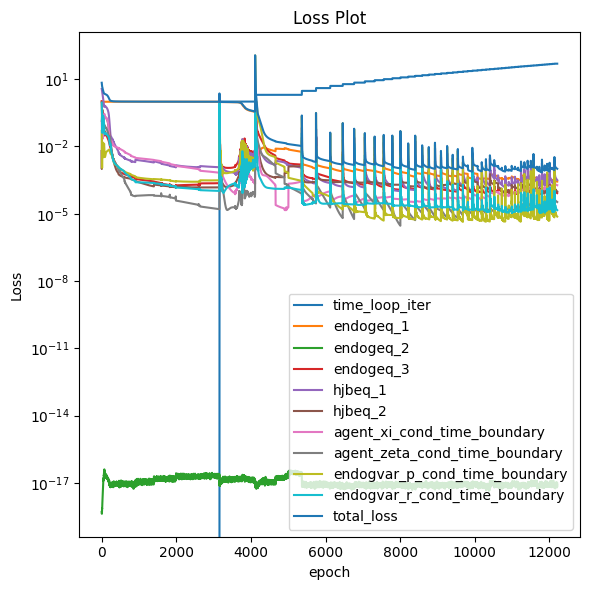

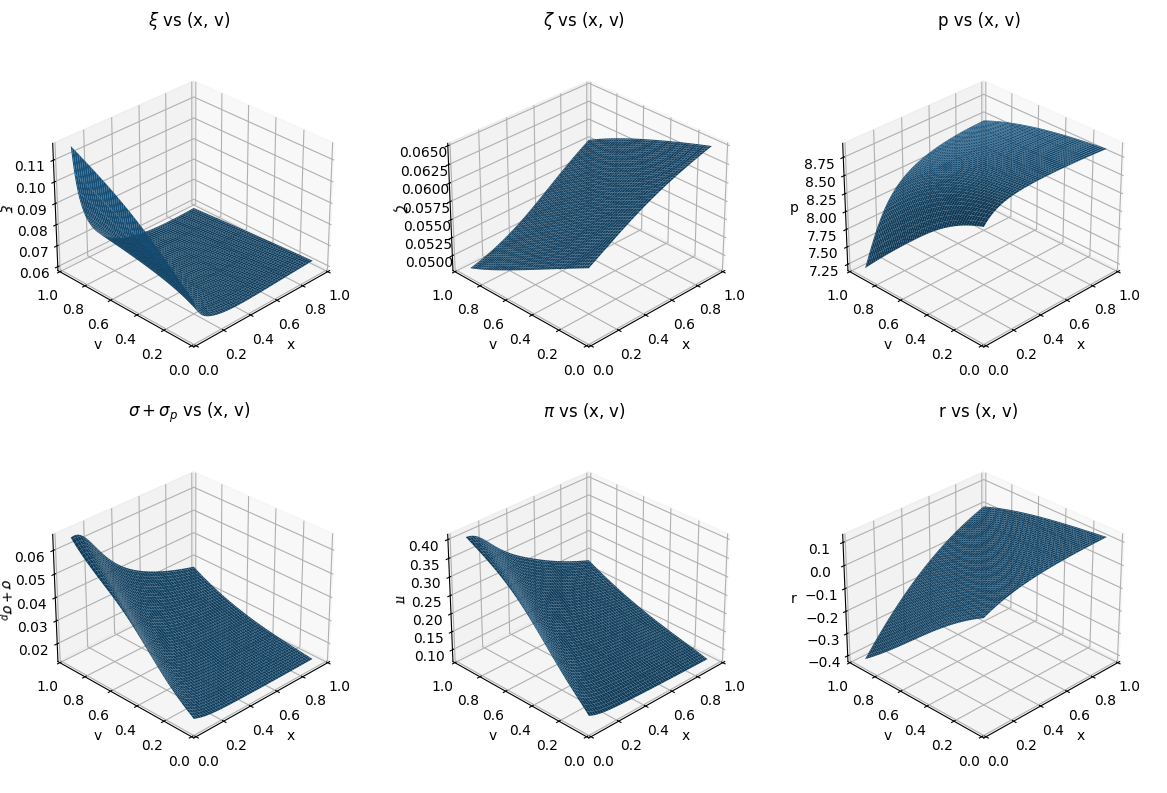

In [4]:
plot_loss_df(fn=f"{MODEL_DIR}/model_min_loss.csv", loss_plot_fn=f"{MODEL_DIR}/model_min_loss.png")
pde_model.plot_vars([r"$\xi$", r"$\zeta$", "p", 
                     r"$\sigma+\sigma_p = \sigma + \sigma_p$", r"$\pi$", "r"], ncols=3)

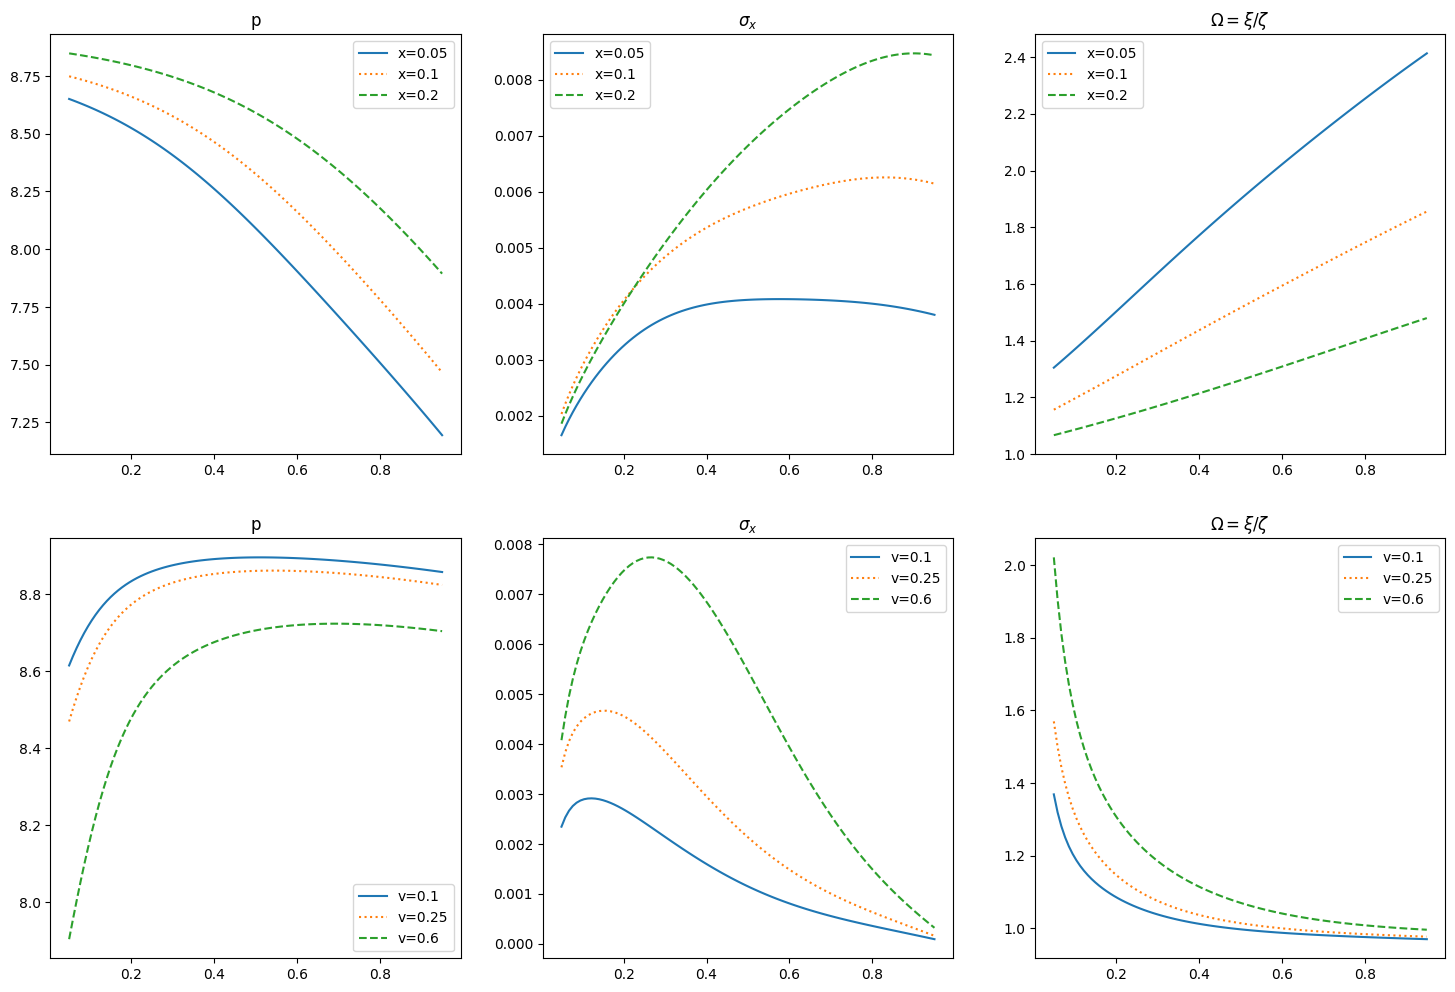

In [5]:
fig, ax = plt.subplots(2, 3, figsize=(18, 12))
for x_val, linestyle in [(0.05, "-"), (0.1, ":"), (0.2, "--")]:
    sv = torch.ones((100, 3), device=pde_model.device) * x_val
    sv[:, 1] = torch.linspace(0.05, 0.95, 100, device=pde_model.device)
    sv[:, 2] = torch.zeros((100,), device=pde_model.device)
    for i, sv_name in enumerate(pde_model.state_variables):
        pde_model.variable_val_dict[sv_name] = sv[:, i:i+1]
    pde_model.update_variables(sv)
    p = pde_model.variable_val_dict["p"]
    sigx = pde_model.variable_val_dict["sigx"]
    omega = pde_model.variable_val_dict["xi"] / pde_model.variable_val_dict["zeta"]
    ax[0][0].plot(sv[:, 1].detach().cpu().numpy(), p.detach().cpu().numpy().reshape(-1), linestyle=linestyle, label=f"x={x_val}")
    ax[0][1].plot(sv[:, 1].detach().cpu().numpy(), sigx.detach().cpu().numpy().reshape(-1), linestyle=linestyle, label=f"x={x_val}")
    ax[0][2].plot(sv[:, 1].detach().cpu().numpy(), omega.detach().cpu().numpy().reshape(-1), linestyle=linestyle, label=f"x={x_val}")
    ax[0][0].set_title(r"p")
    ax[0][1].set_title(r"$\sigma_x$")
    ax[0][2].set_title(r"$\Omega = \xi/\zeta$")
    ax[0][0].legend()
    ax[0][1].legend()
    ax[0][2].legend()

for v_val, linestyle in [(0.1, "-"), (0.25, ":"), (0.6, "--")]:
    sv = torch.ones((100, 3), device=pde_model.device) * v_val
    sv[:, 0] = torch.linspace(0.05, 0.95, 100, device=pde_model.device)
    sv[:, 2] = torch.zeros((100,), device=pde_model.device)
    for i, sv_name in enumerate(pde_model.state_variables):
        pde_model.variable_val_dict[sv_name] = sv[:, i:i+1]
    pde_model.update_variables(sv)
    p = pde_model.variable_val_dict["p"]
    sigx = pde_model.variable_val_dict["sigx"]
    omega = pde_model.variable_val_dict["xi"] / pde_model.variable_val_dict["zeta"]
    ax[1][0].plot(sv[:, 0].detach().cpu().numpy(), p.detach().cpu().numpy().reshape(-1), linestyle=linestyle, label=f"v={v_val}")
    ax[1][1].plot(sv[:, 0].detach().cpu().numpy(), sigx.detach().cpu().numpy().reshape(-1), linestyle=linestyle, label=f"v={v_val}")
    ax[1][2].plot(sv[:, 0].detach().cpu().numpy(), omega.detach().cpu().numpy().reshape(-1), linestyle=linestyle, label=f"v={v_val}")
    ax[1][0].set_title(r"p")
    ax[1][1].set_title(r"$\sigma_x$")
    ax[1][2].set_title(r"$\Omega = \xi/\zeta$")
    ax[1][0].legend()
    ax[1][1].legend()
    ax[1][2].legend()

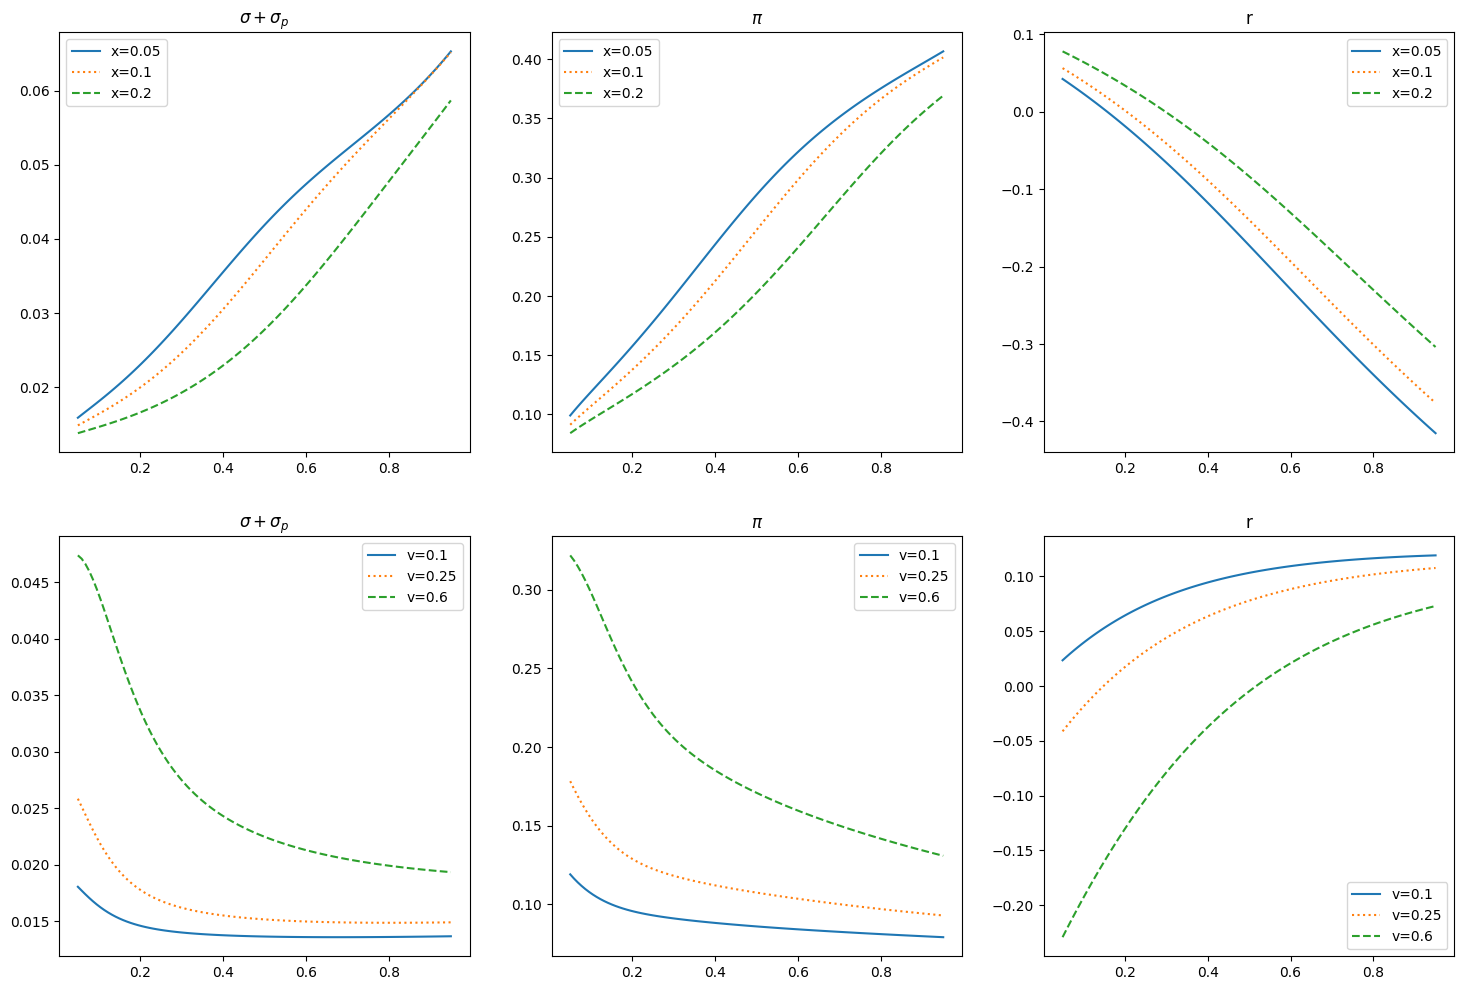

In [6]:
fig, ax = plt.subplots(2, 3, figsize=(18, 12))
for x_val, linestyle in [(0.05, "-"), (0.1, ":"), (0.2, "--")]:
    sv = torch.ones((100, 3), device=pde_model.device) * x_val
    sv[:, 1] = torch.linspace(0.05, 0.95, 100, device=pde_model.device)
    sv[:, 2] = torch.zeros((100,), device=pde_model.device)
    for i, sv_name in enumerate(pde_model.state_variables):
        pde_model.variable_val_dict[sv_name] = sv[:, i:i+1]
    pde_model.update_variables(sv)
    sigsigp = pde_model.variable_val_dict["sigma"] + pde_model.variable_val_dict["sigp"]
    pi = pde_model.variable_val_dict["signxi"]
    r = pde_model.variable_val_dict["r"]
    ax[0][0].plot(sv[:, 1].detach().cpu().numpy(), sigsigp.detach().cpu().numpy().reshape(-1), linestyle=linestyle, label=f"x={x_val}")
    ax[0][1].plot(sv[:, 1].detach().cpu().numpy(), pi.detach().cpu().numpy().reshape(-1), linestyle=linestyle, label=f"x={x_val}")
    ax[0][2].plot(sv[:, 1].detach().cpu().numpy(), r.detach().cpu().numpy().reshape(-1), linestyle=linestyle, label=f"x={x_val}")
    ax[0][0].set_title(r"$\sigma+\sigma_p$")
    ax[0][1].set_title(r"$\pi$")
    ax[0][2].set_title("r")
    ax[0][0].legend()
    ax[0][1].legend()
    ax[0][2].legend()
for v_val, linestyle in [(0.1, "-"), (0.25, ":"), (0.6, "--")]:
    sv = torch.ones((100, 3), device=pde_model.device) * v_val
    sv[:, 0] = torch.linspace(0.05, 0.95, 100, device=pde_model.device)
    sv[:, 2] = torch.zeros((100,), device=pde_model.device)
    for i, sv_name in enumerate(pde_model.state_variables):
        pde_model.variable_val_dict[sv_name] = sv[:, i:i+1]
    pde_model.update_variables(sv)
    sigsigp = pde_model.variable_val_dict["sigma"] + pde_model.variable_val_dict["sigp"]
    pi = pde_model.variable_val_dict["signxi"]
    r = pde_model.variable_val_dict["r"]
    ax[1][0].plot(sv[:, 0].detach().cpu().numpy(), sigsigp.detach().cpu().numpy().reshape(-1), linestyle=linestyle, label=f"v={v_val}")
    ax[1][1].plot(sv[:, 0].detach().cpu().numpy(), pi.detach().cpu().numpy().reshape(-1), linestyle=linestyle, label=f"v={v_val}")
    ax[1][2].plot(sv[:, 0].detach().cpu().numpy(), r.detach().cpu().numpy().reshape(-1), linestyle=linestyle, label=f"v={v_val}")
    ax[1][0].set_title(r"$\sigma+\sigma_p$")
    ax[1][1].set_title(r"$\pi$")
    ax[1][2].set_title("r")
    ax[1][0].legend()
    ax[1][1].legend()
    ax[1][2].legend()

(400, 3)
(400, 3)
(500, 3)
(400, 3)
(500, 3)


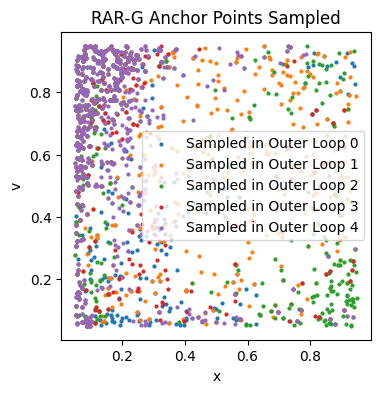

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
for i in range(5):
    anchor_points = np.load(f"{MODEL_DIR}/anchor_points/model_anchor_points_{i}.npy")
    print(anchor_points.shape)
    ax.scatter(anchor_points[:,0], anchor_points[:,1], s=4, label=f"Sampled in Outer Loop {i}")
ax.set_xlabel("x")
ax.set_ylabel("v")
ax.legend()
ax.set_title("RAR-G Anchor Points Sampled")
plt.show()